# Hybrid Pipeline
using lambeq

Lambeq is a python library made by Quantinuum to give researchers the possibility to work on not only classical but also hybrid and quantum pipelines for NLP(natural language processing).

Both the classical and the quantum pipelines contain a quantum part but they differ in the trainer in which the hybrid approach uses a classical trainer while the quantum approach uses a quantum trainer.

In this notebook we are going to implement the hybrid pipeline and get the accuracy to then be able to compare this case with other cases like the quantum and classical case.

pytket-qiskit is an extension to Pytket that allows Pytket circuits to be run on IBM backends and simulators. 

In [2]:
# %pip install lambeq
# %pip install pytket-qiskit

In [3]:
import os
import warnings
import numpy as np


warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

EPOCHS is the max number of iterations that can be performed by the trainer.

The batch size is a number of samples processed before the model is updated.

In [4]:
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

combining all sentences into 1 file.

In [6]:
import glob

read_files = glob.glob("data/*.txt")

with open("data/sentences_file_result.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

splitting sentences for training and testing.

In [7]:
with open("data/sentences_file_result.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[:250]

with open("data/sentences_file_result_train.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

In [8]:
with open("data/sentences_file_result.txt", "r", encoding="utf-8") as source_file:
    lines = source_file.readlines()[251:]

with open("data/sentences_file_result_test.txt", "w", encoding="utf-8") as output_file:
    output_file.writelines(lines)

adding the labes and sentences into separate lists

In [9]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('data/sentences_file_result_train.txt')
val_labels, val_data = read_data('data/sentences_file_result_test.txt')

In [10]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    EPOCHS = 1

In [11]:
train_data[:5]

['I  liked product and quality .',
 'Nice look and super product .',
 'Value for money .',
 'Good watch all are ok in this price but one is battery drain little soon .',
 'So far i liked the most is the battery capacity for last 15days am still not charged the watch once it is 100% changed and it is still on 65%,  in built mic and speaker are both very good .']

In [12]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

Lambeq uses what we call categorical quantum mechanics in which  states, effects, scalars and other metrics can be transformed to a diagram shape. In our case sentences can be transformed into diagrams of boxes and wires then this diagram can be transformed later into a quantum circuit using zx calculus.

In [14]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'),verbose='progress')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)



















Evaluating checksum: 100.0%|█████████▉|1.533/1.533GB [00:01<00:00]


Extracting model...


In [15]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

Here comes the quantum part in which a quantum ansatz called IQPAnsatz is used. An ansatz serves as an initial point or a starting circuit for our quantum computer to execute. The provided sentences can contain nouns, verbs and other components each of which has its own value or score.

In [16]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

atomic_types = {
    AtomicType.NOUN: 1,
    AtomicType.SENTENCE: 0
}

ansatz = IQPAnsatz(atomic_types, n_layers=1, n_single_qubit_params=3)

train_circuits = []
val_circuits = []

for i, diagram in enumerate(train_diagrams):
    try:
        train_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in train_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")

for i, diagram in enumerate(val_diagrams):
    try:
        val_circuits.append(ansatz(remove_cups(diagram)))
    except KeyError as e:
        print(f"Ignoring the error in val_diagram {i + 1}: {e}")
        print(f"Problematic diagram text: {diagram}")

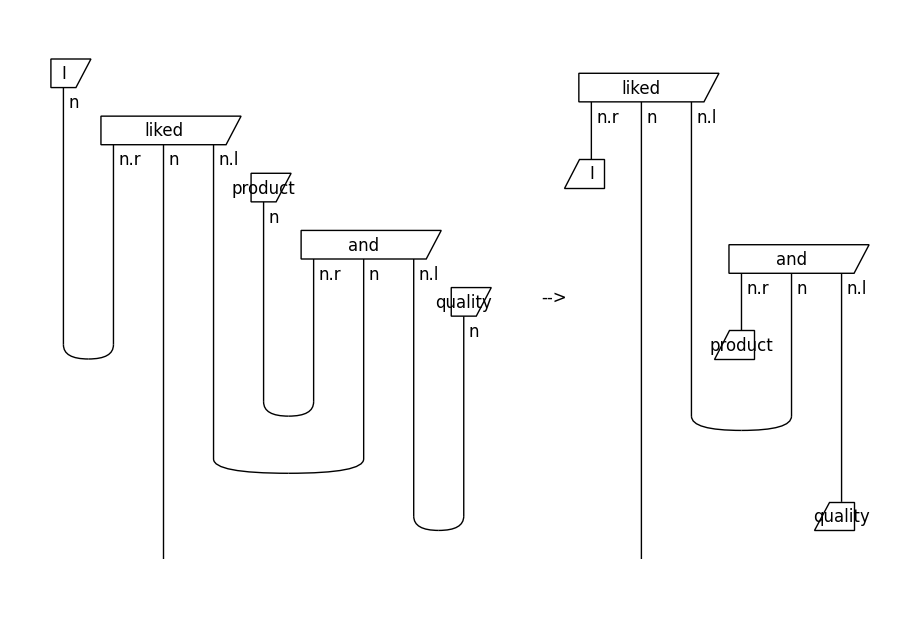

In [17]:
from discopy.drawing import Equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

Equation(original_diagram, removed_cups_diagram, symbol='-->').draw(figsize=(9, 6), asymmetry=0.3, fontsize=12)

To run our quantum circuit we can use real quantum computers or simulators from pennylane and qiskit. In our case we will be using a local simulator from qiskit called AerBackend.

In [18]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [19]:
from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [20]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

creating the dataset in a format which is suitable to be used by the trainer.

In [21]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [22]:
trainer.fit(train_dataset, val_dataset, early_stopping_interval=10)

Epoch 1:    train/loss: 2.5945   valid/loss: 2.2441   train/acc: 0.5171   valid/acc: 0.5085
Epoch 2:    train/loss: 0.3044   valid/loss: 2.1049   train/acc: 0.5200   valid/acc: 0.4746
Epoch 3:    train/loss: 1.0605   valid/loss: 2.4780   train/acc: 0.5600   valid/acc: 0.4322
Epoch 4:    train/loss: 4.8939   valid/loss: 2.7768   train/acc: 0.5257   valid/acc: 0.5000
Epoch 5:    train/loss: 0.5742   valid/loss: 1.7172   train/acc: 0.5057   valid/acc: 0.5339
Epoch 6:    train/loss: 2.4009   valid/loss: 1.6530   train/acc: 0.5543   valid/acc: 0.5678
Epoch 7:    train/loss: 0.6842   valid/loss: 2.4008   train/acc: 0.5457   valid/acc: 0.5000
Epoch 8:    train/loss: 0.6129   valid/loss: 1.4215   train/acc: 0.5314   valid/acc: 0.4915
Epoch 9:    train/loss: 0.8494   valid/loss: 2.4253   train/acc: 0.5200   valid/acc: 0.5000
Epoch 10:   train/loss: 2.9218   valid/loss: 1.3601   train/acc: 0.5543   valid/acc: 0.5424
Epoch 11:   train/loss: 0.9045   valid/loss: 2.3480   train/acc: 0.5429   valid/

Validation accuracy: 0.5677966101694916


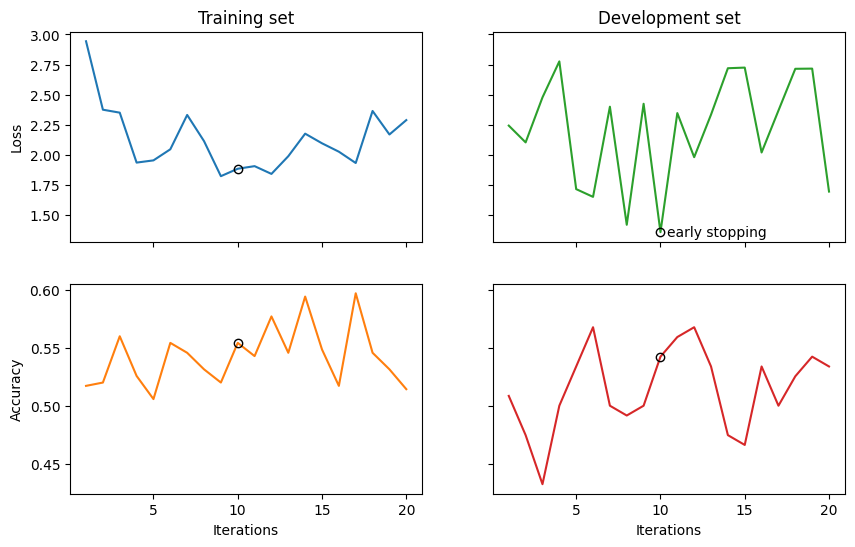

In [23]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmin(trainer.val_costs)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())